# Regression Limited Input Approach
This approach assumes that input for both training and testing is just limited to its coordinates (X,Y,Z) and that testing is just using the first trajectory coordinate of an observation group. Based on these coordinates, we will group them up based on their observation groups and generate significant features such as human positions, initial velocity, initial slant angle and initial firing angle using mathematical formulas which will be used to train models for predictions. 


Random Forest Regressor is used to predict the data points of the trajectory, Decision Tree Classifier is used to determine number of observations an observation groups has. 

## Importing Libraries and Dependencies

In [1]:
%pip install pandas
%pip install matplotlib
%pip install plotly
%pip install scikit-learn
%pip install numpy
%pip install nbformat

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# preprocessing and feature generation
import pandas as pd
import numpy as np
import math
import random

# feature significance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# data mining and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import learning_curve

# visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot

## Stage: Preprocessing
Mockup data with just X, Y, Z values by removing the rest of the value.

In [3]:
# # read csv data from badmintondata.csv
# limited_serving_data = pd.read_csv('badmintondata.csv')

# # just rename x metrics to avoid unnecessary errors
# limited_serving_data = limited_serving_data.rename(columns={'SHUTTLECOCK POSITIION IN AIR(X ) metres': 'SHUTTLECOCK POSITIION IN AIR(X) metres'})

# # limiting service data to just x, y, z coordinates
# limited_serving_data = limited_serving_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Z) metres']]
# limited_serving_data

In [4]:
# # read csv data from badmintondata.csv
# limited_rallying_data = pd.read_csv('badmintondata2.csv')

# # just rename x metrics to avoid unnecessary errors
# limited_rallying_data = limited_rallying_data.rename(columns={'SHUTTLECOCK POSITIION IN AIR(X ) metres': 'SHUTTLECOCK POSITIION IN AIR(X) metres'})

# # limiting service data to just x, y, z coordinates
# limited_rallying_data = limited_rallying_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Z) metres']]
# limited_rallying_data

Assigning data to observation groups and labelling their sequences with observation numbers

In [5]:
# # Initialize variables
# observation_group_num = 0
# observation_num = 0
# is_group = False

# # assign observation groups and their respective observation numbers to each row
# for index, row in limited_serving_data.iterrows():
#     if row['SHUTTLECOCK POSITIION IN AIR(X) metres'] == 0:
#         if is_group:
#             is_group = False
#         limited_serving_data.drop(index, inplace=True)
#     # if row is not empty
#     else:
#         # if inside an observation group just increment observation number
#         if is_group:
#             observation_num+=1
#         # if just entering a new observation group
#         else:
#             is_group = True
#             # increase observation group number by 1
#             observation_group_num+=1
#             # resets observation sequence number to 1
#             observation_num = 1
#         # assign observation group and observation number
#         limited_serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#         limited_serving_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# # Set 'OBSERVATION GROUP NUMBER' as INT
# limited_serving_data['OBSERVATION GROUP NUMBER'] = limited_serving_data['OBSERVATION GROUP NUMBER'].astype(int)
# limited_serving_data.to_csv('regression_data/limited_serving_data_stage1.csv')

In [6]:
# # Initialize variables
# observation_group_num = 364 # last observation group number index from dataset 1
# observation_num = 0
# is_group = False

# # assign observation groups and their respective observation numbers to each row
# for index, row in limited_rallying_data.iterrows():
#     if row['SHUTTLECOCK POSITIION IN AIR(X) metres'] == 0:
#         if is_group:
#             is_group = False
#         limited_rallying_data.drop(index, inplace=True)
#     # if row is not empty
#     else:
#         # if inside an observation group just increment observation number
#         if is_group:
#             observation_num+=1
#         # if just entering a new observation group
#         else:
#             is_group = True
#             # increase observation group number by 1
#             observation_group_num+=1
#             # resets observation sequence number to 1
#             observation_num = 1
#         # assign observation group and observation number
#         limited_rallying_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#         limited_rallying_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# # Set 'OBSERVATION GROUP NUMBER' as INT
# limited_rallying_data['OBSERVATION GROUP NUMBER'] = limited_rallying_data['OBSERVATION GROUP NUMBER'].astype(int)
# limited_rallying_data.to_csv('regression_data/limited_rallying_data_stage1.csv')

Determining the initial starting position of each shuttlecock by either rounding it down, or rounding it to nearest necessary value 

In [7]:
# load in last milestone to save time 
limited_serving_data = pd.read_csv('regression_data/limited_serving_data_stage1.csv')
limited_serving_data = limited_serving_data.drop(columns=('Unnamed: 0'))
limited_rallying_data = pd.read_csv('regression_data/limited_rallying_data_stage1.csv')
limited_rallying_data = limited_rallying_data.drop(columns=('Unnamed: 0'))

# Add Initial Points of Human Position based on the rounded down version of the first point
# Reset the index before applying groupby
def calculate_human_position(group):
    rounded_value_x = math.floor(group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(X) metres'])
    rounded_value_y = round(group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Y) metres'])
    rounded_value_z = rounded_value = min(1.6, 2.6, key=lambda x: abs(x - group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Z) metres']))
    group['HUMAN PLAYER POSITION (X) metres'] = rounded_value_x
    group['HUMAN PLAYER POSITION (Y) metres'] = rounded_value_y
    group['HUMAN PLAYER POSITION (Z) metres'] = rounded_value_z
    return group

# Apply the function to serving data in each group using groupby and apply
limited_serving_data = limited_serving_data.groupby('OBSERVATION GROUP NUMBER').apply(calculate_human_position)
limited_serving_data = limited_serving_data.reset_index(drop=True)

# Apply the function to rallying data in each group using groupby and apply
limited_rallying_data = limited_rallying_data.groupby('OBSERVATION GROUP NUMBER').apply(calculate_human_position)
limited_rallying_data = limited_rallying_data.reset_index(drop=True)

C:\Users\evely\AppData\Local\Temp\ipykernel_14072\410818634.py:19: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

C:\Users\evely\AppData\Local\Temp\ipykernel_14072\410818634.py:23: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



Creating Velocity, Slant Angles and Firing Angles of each shuttlecock using mathematical equation with X,Y,Z manipulation

In [8]:
def generate_features(group):
    # calculate X,Y,Z distances from initial human points
    X_displacement = group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(X) metres'] - group.iloc[0]['HUMAN PLAYER POSITION (X) metres']
    Y_displacement = group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Y) metres'] - group.iloc[0]['HUMAN PLAYER POSITION (Y) metres'] 
    Z_displacement = group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Z) metres'] - group.iloc[0]['HUMAN PLAYER POSITION (Z) metres']

    # calculate initial firing angle
    firing_angle_radians = math.atan(X_displacement / Z_displacement)
    firing_angle_degrees = math.degrees(firing_angle_radians)
    # round to nearest 10 for firing angle
    group['INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'] = round(firing_angle_degrees / 10) * 10

    # calculate initial slant angle
    slant_angle_radians = math.atan(Y_displacement / X_displacement)
    slant_angle_degrees = math.degrees(slant_angle_radians)
    group['INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'] = round(slant_angle_degrees)

    # Calculate the initial velocity (v₀)
    time_elapsed = 0.1
    displacement = math.sqrt(X_displacement**2 + Y_displacement**2 + Z_displacement**2)
    initial_velocity = round(displacement/time_elapsed)
    # round to nearest 10 for velocity
    group['INITITAL VELOCITY OF SHUTTELCOCK(m/s)'] = initial_velocity
    return group

# generate features for serving data
limited_serving_data = limited_serving_data.groupby('OBSERVATION GROUP NUMBER').apply(generate_features)
limited_serving_data = limited_serving_data.reset_index(drop=True)
limited_serving_data.to_csv('regression_data/limited_serving_data.csv')

# generate features for rallying data
limited_rallying_data = limited_rallying_data.groupby('OBSERVATION GROUP NUMBER').apply(generate_features)
limited_rallying_data = limited_rallying_data.reset_index(drop=True)
limited_rallying_data.to_csv('regression_data/limited_rallying_data.csv')

C:\Users\evely\AppData\Local\Temp\ipykernel_14072\3872537049.py:27: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

C:\Users\evely\AppData\Local\Temp\ipykernel_14072\3872537049.py:32: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



Combine the two datasets into a single dataset

In [9]:
# combining the serving and rally dataframes
limited_badminton_data = pd.concat([limited_serving_data, limited_rallying_data], ignore_index=True)
limited_badminton_data.to_csv('regression_data/limited_badminton_data.csv')

label data if they are are out of bounds within the observations using data column "OUT OF BOUNDS". This includes
- Data that exceeds the X axis (hit too far on both sides) X < 0 OR X > 13.4
- Data that exceeds the Y axis (hit out of court on left or right side) Y < 0 OR Y > 5.18
- Data that is out of bounds labelled as 1, no 0

OPTIONAL, if needed

In [10]:
# # labelling data if its out of bounds
# unique_observation_number = limited_badminton_data['OBSERVATION GROUP NUMBER'].unique()
# for obs_grp_number in unique_observation_number:
#     last_row = limited_badminton_data[limited_badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number].tail(1)
#     # Check the conditions for 'Shuttlecock Position in Air X' and 'Shuttlecock Position in Air Y'
#     if (last_row['SHUTTLECOCK POSITIION IN AIR(X) metres'].values[0] < 0 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(X) metres'].values[0] > 13.4 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] < 0 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] > 5.18):
        
#         # Set 'OUT OF BOUNDS' column to 1 for the corresponding observation number
#         limited_badminton_data.loc[limited_badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number, 'OUT OF BOUNDS'] = 1
#     else:
#         limited_badminton_data.loc[limited_badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number, 'OUT OF BOUNDS']

## Feature Significance
Selecting features to test significance using PCA and standardizing them. 

In [11]:
# removal of labels and dependent features
X_limited_features = limited_badminton_data.drop(columns=['OBSERVATION GROUP NUMBER',
                                            'SHUTTLECOCK POSITIION IN AIR(X) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Z) metres'])
# Standardize the data
scaler = StandardScaler()
X_features_norm = scaler.fit_transform(X_limited_features)

Feature INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE): Significance = 0.18653208130233231
Feature HUMAN PLAYER POSITION (Z) metres: Significance = 0.17677218072799952
Feature OBSERVATION NUMBER: Significance = 0.15130267848958967
Feature INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE): Significance = 0.15067646190778108
Feature INITITAL VELOCITY OF SHUTTELCOCK(m/s): Significance = 0.13679930347016347
Feature HUMAN PLAYER POSITION (Y) metres: Significance = 0.11239037013040598
Feature HUMAN PLAYER POSITION (X) metres: Significance = 0.08552692397172786


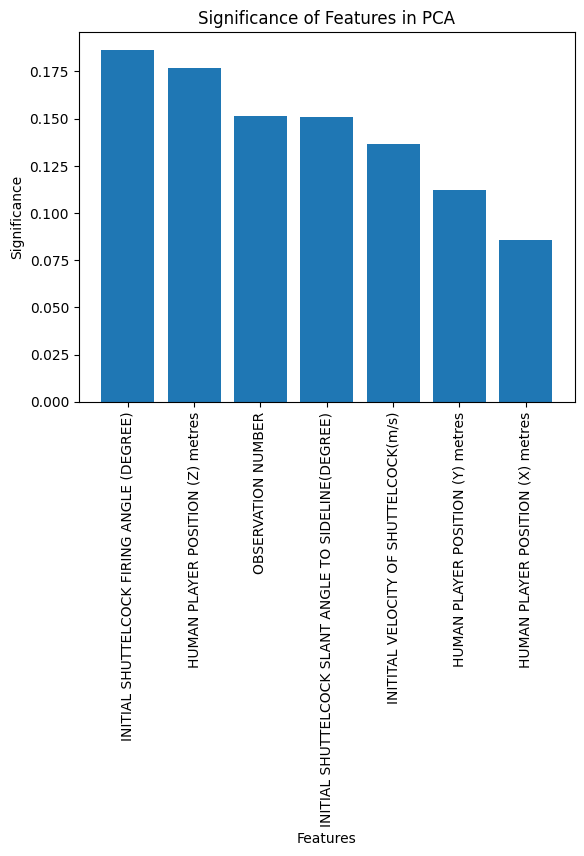

In [12]:
# instantiate PCA object, fit model
pca = PCA()
pca.fit(X_features_norm)

# loadings refer to the coefficients or weights that determine the contribution of each feature to the principal components
# Get the absolute loadings for each feature in each principal component
absolute_loadings = np.abs(pca.components_)
# Calculate the total sum of absolute loadings for each feature across all principal components
total_loadings = np.sum(absolute_loadings, axis=0)

# Calculate the relative contribution of each feature to the total loadings
relative_contribution = total_loadings / np.sum(total_loadings)

# Sort the features based on their relative contribution
sorted_features = np.argsort(relative_contribution)[::-1]
feature_names = X_limited_features.columns
# Print the significance of each feature
for feature_idx in sorted_features:
    print(f"Feature {feature_names[feature_idx]}: Significance = {relative_contribution[feature_idx]}")

# Plot the significance of each feature
plt.bar(range(len(sorted_features)), relative_contribution[sorted_features])
plt.xlabel('Features')
plt.ylabel('Significance')
plt.title('Significance of Features in PCA')
plt.xticks(range(len(sorted_features)), feature_names[sorted_features], rotation=90)
# plt.xticks(range(len(sorted_features)), sorted_features)
plt.show()

## Stage: Data Mining
### Preparing data for Decision Tree Classifier
To determine observation steps needed for a trajectory, only these X features are needed. No normalization is needed
- 'HUMAN PLAYER POSITION (X) metres'
- 'HUMAN PLAYER POSITION (Y) metres'
- 'HUMAN PLAYER POSITION (Z) metres'
- 'INITITAL VELOCITY OF SHUTTELCOCK(m/s)'
- 'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'
- 'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'

In [13]:
# loading data
temp_data = pd.read_csv('regression_data/limited_badminton_data.csv')
temp_data = temp_data.drop(columns=['Unnamed: 0'])

# Drop duplicates based on 'Observation Group Number', keeping only the last record
data_DT = temp_data.copy()
data_DT = data_DT.drop_duplicates(subset='OBSERVATION GROUP NUMBER', keep='last')

# Define X and Y Features for Decision Tree
X_features_DT = data_DT[['HUMAN PLAYER POSITION (X) metres', 
                            'HUMAN PLAYER POSITION (Y) metres',
                            'HUMAN PLAYER POSITION (Z) metres', 
                            'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                            'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                            'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]

Y_feature_DT = data_DT['OBSERVATION NUMBER']

# Split the data into train/test, X/Y for Decision Tree Classifier
X_train_DT, X_test_DT, Y_train_DT, Y_test_DT = train_test_split(X_features_DT, Y_feature_DT, test_size=0.2, random_state=42)

### Finding Optimal Decision Tree Model
To predict total observation time based on the independent feature supplied. Predicts a set of observation take

In [14]:
from sklearn.tree import DecisionTreeClassifier
maxdepths = [2,3,4,5,6,7,8,9,10,15]  # 10 different depths

# containers to store train/test accuracy rates
trainAcc_DT = np.zeros(len(maxdepths))
testAcc_DT = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    # training decision tree with depth lengths
    temp_model_DT = DecisionTreeClassifier(max_depth=depth)
    temp_model_DT = temp_model_DT.fit(X_train_DT, Y_train_DT)
    # generate predictions using the model trained, for the training data (X) and test data (X)
    Y_predTrain = temp_model_DT.predict(X_train_DT)
    Y_predTest = temp_model_DT.predict(X_test_DT)
    # compare the predicted values and compare against original values for accuracy
    trainAcc_DT[index] = accuracy_score(Y_train_DT, Y_predTrain)
    testAcc_DT[index] = accuracy_score(Y_test_DT, Y_predTest)
    index += 1

Text(0, 0.5, 'Accuracy')

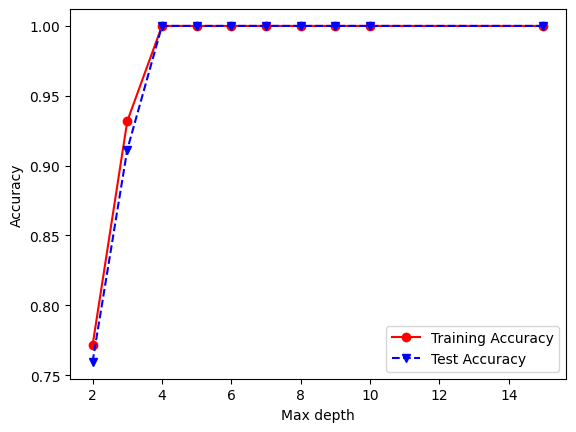

In [15]:
plt.plot(maxdepths,trainAcc_DT,'ro-',maxdepths,testAcc_DT,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

### Train Decision Tree Model "Model_DecisionTree"
Using the optimal elbow depth found in the previous segment which is 4

In [16]:
model_decisionTree = DecisionTreeClassifier(max_depth=4)
model_decisionTree = model_decisionTree.fit(X_train_DT, Y_train_DT)

Y_predTrain = model_decisionTree.predict(X_train_DT)
Y_predTest = model_decisionTree.predict(X_test_DT)

trainAcc_DT = accuracy_score(Y_train_DT, Y_predTrain)
testAcc_DT = accuracy_score(Y_test_DT, Y_predTest)
print("Training Accuracy: ", trainAcc_DT)
print("Testing Accuracy: ", testAcc_DT)

Training Accuracy:  1.0
Testing Accuracy:  1.0


### Preparing data for Regressor Models

In [17]:
# define x and y features
X_features_Regression = temp_data[['HUMAN PLAYER POSITION (X) metres', 
                        'HUMAN PLAYER POSITION (Y) metres', 
                        'HUMAN PLAYER POSITION (Z) metres',
                        'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                        'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                        'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                        'OBSERVATION NUMBER']]

Y_features_Regression = temp_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
                        'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                        'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

# contains all the observation group numbers in data
unique_observation_grps = temp_data['OBSERVATION GROUP NUMBER'].unique() # list of [1 to 1576]
# shuffle order
random.shuffle(unique_observation_grps)

# index of training sets
training_test_split_idx = int(0.8*len(unique_observation_grps))
# containers to store all the respective train and test observation groups idx from data
train_idxes = unique_observation_grps[:training_test_split_idx]
test_idxes = unique_observation_grps[training_test_split_idx:]

train_data = temp_data[temp_data['OBSERVATION GROUP NUMBER'].isin(train_idxes)]
test_data = temp_data[temp_data['OBSERVATION GROUP NUMBER'].isin(test_idxes)]

# Define X and Y features
X_train_Regression = train_data[['HUMAN PLAYER POSITION (X) metres', 
                        'HUMAN PLAYER POSITION (Y) metres', 
                        'HUMAN PLAYER POSITION (Z) metres',
                        'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                        'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                        'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                        'OBSERVATION NUMBER']]

Y_train_Regression = train_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
                      'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                      'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

X_test_Regression = test_data[['HUMAN PLAYER POSITION (X) metres', 
                        'HUMAN PLAYER POSITION (Y) metres', 
                        'HUMAN PLAYER POSITION (Z) metres',
                        'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                        'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                        'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                        'OBSERVATION NUMBER']]

Y_test_Regression = test_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
                    'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                    'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

### Random Forest Regressor
Random Forest is an ensemble learning algorithm that combines multiple decision trees to make predictions. It can handle both numerical and categorical data and is capable of capturing complex relationships in the data. It does not require feature standardization as they are not sensitive to the scale of the features. Random Forest algorithms work by creating decision trees based on random subsets of features, and each decision tree independently makes decisions based on these features.
#### Dependencies for Random Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor  # for regression tasks

#### Optimizing Random Forest Regressor
Building multiple models with different depths to find best model with lowest mean squared error. Best depth should be 15

In [19]:
# # Define a list of depths to test
# depths = [5, 10, 15, 20, 25, 30]
# mse_score_RF = []

# # Iterate over different depths and calculate MSE
# for depth in depths:
#     temp_model_RF = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=42)
#     temp_model_RF.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_RF = temp_model_RF.predict(X_test_Regression)
#     mse = mean_squared_error(Y_test_Regression, temp_y_pred_RF)
#     mse_score_RF.append(mse)
# print(mse_score_RF)

In [20]:
# # Plotting the MSE scores
# plt.plot(depths, mse_score_RF, marker='o')
# plt.xlabel('Depth')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. Depth for Random Forest Regressor')
# plt.show()

Building multiple models with different number of decision trees "n_estimators" to find best "n_estimator". Best number of decision trees should be 200

In [21]:
# # Define a list of n_estimators to test
# n_estimators_values = [50, 100, 150, 200, 250, 300]
# mse_score_RF = []

# # Iterate over different n_estimators and calculate MSE
# for n_estimators in n_estimators_values:
#     temp_model_RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=15, random_state=42)
#     temp_model_RF.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_RF = temp_model_RF.predict(X_test_Regression)
#     mse = mean_squared_error(Y_test_Regression, temp_y_pred_RF)
#     mse_score_RF.append(mse)
# print(mse_score_RF)

In [22]:
# # Plotting the MSE scores
# plt.plot(n_estimators_values, mse_score_RF, marker='o')
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. n_estimators for Random Forest Regressor')
# plt.show()

#### Training with Best Random Forest
This model will allow us predict an X, Y, Z coordinate in relation to the independent features supplied

In [23]:
# Define the Random Forest Regressor
model_randomForest = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)  # for regression

model_randomForest.fit(X_train_Regression, Y_train_Regression)
y_pred_RF = model_randomForest.predict(X_test_Regression)

### Training Evaluation of Random Forest
Mean squared error and root mean squared errors are error margin metrics for regression models. Refer to root mean squared error for a closer error margin to original metric

In [24]:
mse = mean_squared_error(Y_test_Regression, y_pred_RF)
print("Mean Squared Error:", mse)
rmse = math.sqrt(mse)
print("Root Squared Error:", rmse)

Mean Squared Error: 0.006309554230944713
Root Squared Error: 0.07943270252827052


Check for generalization of data and if data is able to capture underlying pattern properly. This is done with a learning curve, with a negative mean squared metric. If the training and validation lines converge at a low error rate, that means that the model is well generalized and captures patterns properly

In [25]:
# # Calculate the learning curves
# train_sizes, train_scores, val_scores = learning_curve(model_randomForest, X_train_Regression, Y_train_Regression, cv=5, scoring='neg_mean_squared_error')

# # Calculate the mean and standard deviation of train and validation scores
# train_mean = -np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# val_mean = -np.mean(val_scores, axis=1)
# val_std = np.std(val_scores, axis=1)

In [26]:
# # Plot the learning curves
# plt.figure(figsize=(10, 7))
# plt.plot(train_sizes, train_mean, label='Training score', color='blue')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
# plt.plot(train_sizes, val_mean, label='Validation score', color='red')
# plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
# plt.xlabel('Training Set Size')
# plt.ylabel('Negative Mean Squared Error')
# plt.title('Learning Curve for Random Forest Regressor')
# plt.legend(loc='best')
# plt.show()

### Model Visualization of Random Forest Regressor

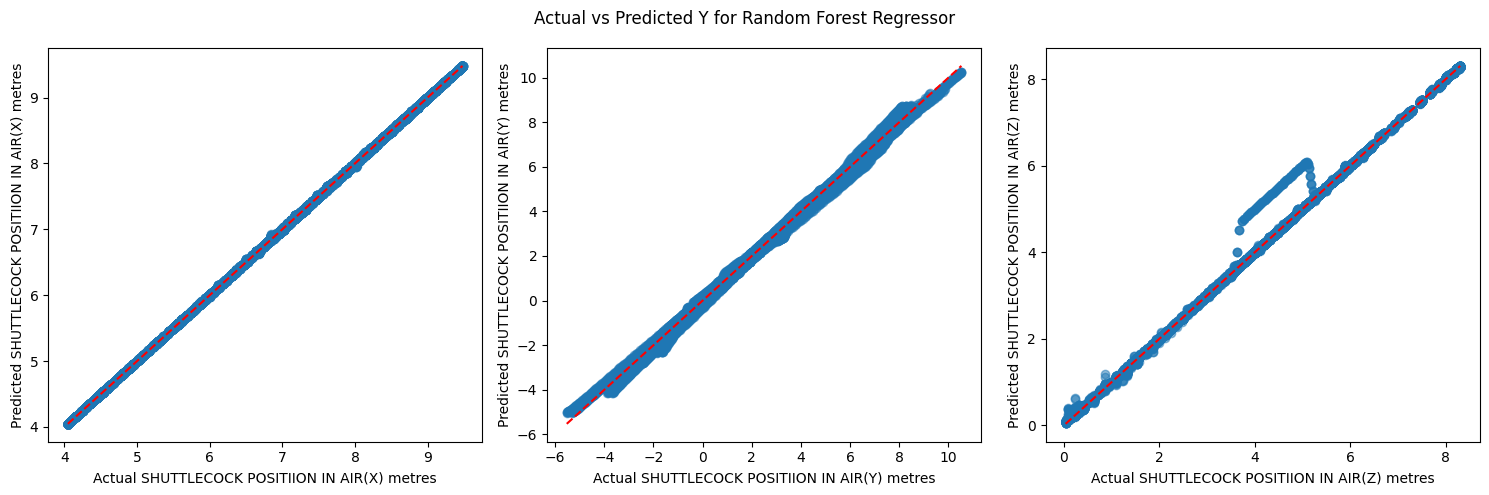

In [27]:
# Plotting the scatterplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plotting for each target variable
for i, target in enumerate(Y_features_Regression.columns):
    ax[i].scatter(Y_test_Regression[target], y_pred_RF[:, i], alpha=0.5)
    ax[i].plot([Y_test_Regression[target].min(), Y_test_Regression[target].max()], [Y_test_Regression[target].min(), Y_test_Regression[target].max()], 'r--')
    ax[i].set_xlabel('Actual ' + target)
    ax[i].set_ylabel('Predicted ' + target)

plt.suptitle('Actual vs Predicted Y for Random Forest Regressor')
plt.tight_layout()
plt.show()

In [28]:
# Create traces for actual and predicted values
actual_trace = go.Scatter3d(
    x=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(X) metres'],
    y=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
    z=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Z) metres'],
    name='Actual',
    mode='markers',
    marker=dict(
        color='blue',
        size=3,
        symbol='circle'
    )
)

predicted_trace = go.Scatter3d(
    x=y_pred_RF[:, 0],
    y=y_pred_RF[:, 1],
    z=y_pred_RF[:, 2],
    name='Predicted',
    mode='markers',
    marker=dict(
        color='red',
        size=3,
        symbol='circle'
    )
)

# Create layout
layout = go.Layout(
    title='Actual vs Predicted Shuttlecock Positions for Random Forest Regressor',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)

# Save the plot as an HTML file
plot(fig, filename='interactive_models/random_forest_limited_model.html')

'interactive_models/random_forest_limited_model.html'

### Extra Trees Regressor
Extra Trees aka. (Extremely Randomized Trees) Regressor is a variant of Random Forest Tree which also uses an ensemble of decision trees to make predictions. However unlike random forests, Extra Trees introduces extra randomness by randomly selecting features at each node split. This randomness helps to create more diverse and less correlated trees. The final prediction is obtained by averaging the predictions of all the trees.
#### Dependencies for Extra Trees Regressor

In [29]:
from sklearn.ensemble import ExtraTreesRegressor

### Optimization of Extra Tree Regressor 
Building multiple models with different depths to find best model with lowest mean squared error. Best depth should be 15

In [30]:
# # Define a list of depths to test
# depths = [5, 10, 15, 20, 25, 30]
# mse_scores_ET = []

# # Iterate over different depths and calculate MSE
# for depth in depths:
#     temp_model_ET = ExtraTreesRegressor(n_estimators=100, max_depth=depth, random_state=42)
#     temp_model_ET.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_ET = temp_model_ET.predict(X_test_Regression)
#     mse = mean_squared_error(Y_test_Regression, temp_y_pred_ET)
#     mse_scores_ET.append(mse)

In [31]:
# # Plotting the MSE scores
# plt.plot(depths, mse_scores_ET, marker='o')
# plt.xlabel('Depth')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. Depth for Extra Trees Regressor')
# plt.show()

Building multiple models with different number of decision trees "n_estimators" to find best "n_estimator". Best number of decision trees should be 200

In [32]:
# # Define a list of n_estimators to test
# n_estimators_values = [50, 100, 150, 200, 250, 300]
# mse_scores_ET = []

# # Iterate over different n_estimators and calculate MSE
# for n_estimators in n_estimators_values:
#     temp_model_ET = RandomForestRegressor(n_estimators=n_estimators, max_depth=15, random_state=42)
#     temp_model_ET.fit(X_train_Regression, Y_train_Regression)
#     temp_y_pred_RF = temp_model_ET.predict(X_test_Regression)
#     mse = mean_squared_error(Y_test_Regression, temp_y_pred_RF)
#     mse_scores_ET.append(mse)
# print(mse_scores_ET)

In [33]:
# # Plotting the MSE scores
# plt.plot(n_estimators_values, mse_scores_ET, marker='o')
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Squared Error')
# plt.title('Mean Squared Error vs. n_estimators for Extra Trees Regressor')
# plt.show()

### Training with Best Extra Trees Regressor
This model will allow us predict an X, Y, Z coordinate in relation to the independent features supplied

In [34]:
# Define the Extra Trees Regressor
model_ExtraTrees = ExtraTreesRegressor()
model_ExtraTrees.fit(X_train_Regression, Y_train_Regression)
y_pred_ET = model_ExtraTrees.predict(X_test_Regression)

### Training Evaluation of Extra Trees Regressor
Mean squared error and root mean squared errors are error margin metrics for regression models. Refer to root mean squared error for a closer error margin to original metric

In [35]:
mse = mean_squared_error(Y_test_Regression, y_pred_ET)
print("Mean Squared Error:", mse)
rmse = math.sqrt(mse)
print("Root Squared Error:", rmse)

Mean Squared Error: 0.0008745922840829946
Root Squared Error: 0.029573506455660523


Check for generalization of data and if data is able to capture underlying pattern properly. This is done with a learning curve, with a negative mean squared metric. If the training and validation lines converge at a low error rate, that means that the model is well generalized and captures patterns properly

In [36]:
# # Calculate the learning curves
# train_sizes, train_scores, val_scores = learning_curve(model_ExtraTrees, X_train_Regression, Y_train_Regression, cv=5, scoring='neg_mean_squared_error')

# # Calculate the mean and standard deviation of train and validation scores
# train_mean = -np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# val_mean = -np.mean(val_scores, axis=1)
# val_std = np.std(val_scores, axis=1)

In [37]:
# # Plot the learning curves
# plt.figure(figsize=(10, 7))
# plt.plot(train_sizes, train_mean, label='Training score', color='blue')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
# plt.plot(train_sizes, val_mean, label='Validation score', color='red')
# plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
# plt.xlabel('Training Set Size')
# plt.ylabel('Negative Mean Squared Error')
# plt.title('Learning Curve for Extra Trees')
# plt.legend(loc='best')
# plt.show()

### Model Visualization of Extra Trees Regressor

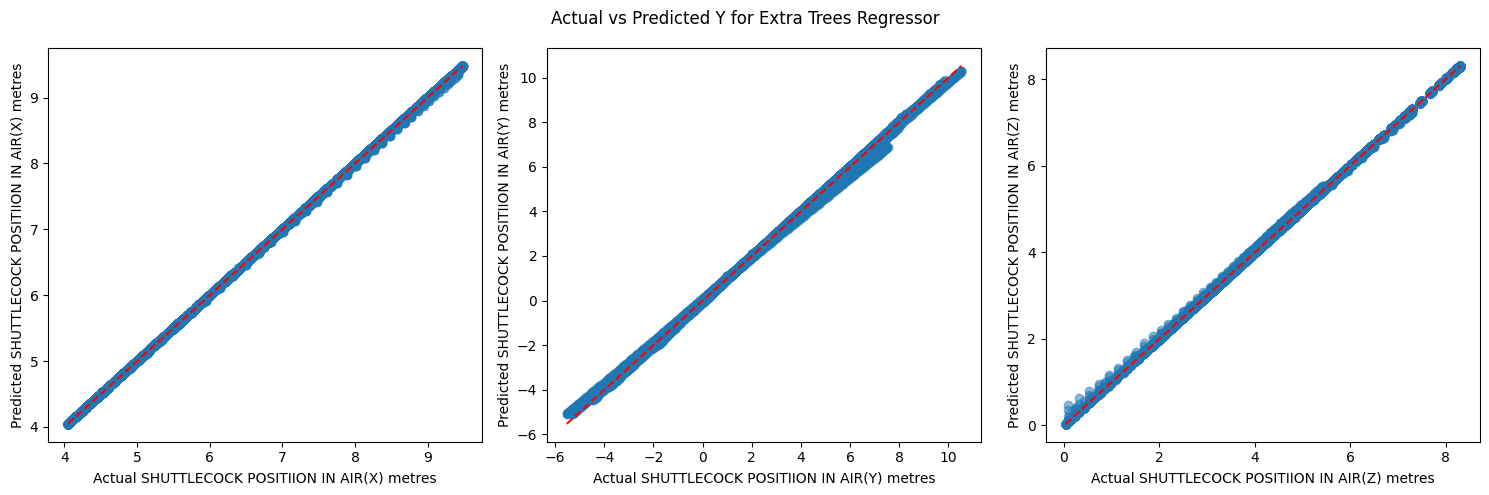

In [38]:
# Plotting the scatterplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plotting for each target variable
for i, target in enumerate(Y_features_Regression.columns):
    ax[i].scatter(Y_test_Regression[target], y_pred_ET[:, i], alpha=0.5)
    ax[i].plot([Y_test_Regression[target].min(), Y_test_Regression[target].max()], [Y_test_Regression[target].min(), Y_test_Regression[target].max()], 'r--')
    ax[i].set_xlabel('Actual ' + target)
    ax[i].set_ylabel('Predicted ' + target)

plt.suptitle('Actual vs Predicted Y for Extra Trees Regressor')
plt.tight_layout()
plt.show()

In [39]:
# Create traces for actual and predicted values
actual_trace = go.Scatter3d(
    x=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(X) metres'],
    y=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
    z=Y_test_Regression['SHUTTLECOCK POSITIION IN AIR(Z) metres'],
    name='Actual',
    mode='markers',
    marker=dict(
        color='blue',
        size=3,
        symbol='circle'
    )
)

predicted_trace = go.Scatter3d(
    x=y_pred_ET[:, 0],
    y=y_pred_ET[:, 1],
    z=y_pred_ET[:, 2],
    name='Predicted',
    mode='markers',
    marker=dict(
        color='red',
        size=3,
        symbol='circle'
    )
)

# Create layout
layout = go.Layout(
    title='Actual vs Predicted Shuttlecock Positions for Extra Trees Regressor',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)

# Save the plot as an HTML file
plot(fig, filename='interactive_models/extra_trees_limited_model.html')

'interactive_models/extra_trees_limited_model.html'

## Stage: Actual Testing with First Coordinate
To actually test if all the models work, the first point of an observation group will be used for testing. Test will be randomized and based on observation group. Assuming that we will know the sequence order of the observation since they are ordered, OBSERVATION NUMBER will be used to identify the first observation

In [40]:
import random
# copied to avoid alterations to cleaned data
test_data = temp_data.copy()

# choose a random from the observation groups to test
unique_observation_grps = test_data['OBSERVATION GROUP NUMBER'].nunique()
selected_test_num = random.randint(1, unique_observation_grps)
print("Selected Observation Group Number is :", selected_test_num)

# alternatively can hardcode to replicate results
# selected_test_num = ?

# retrieve all the rows from the data related to randomly selected row
y_actual_records = test_data[test_data['OBSERVATION GROUP NUMBER'] == selected_test_num]

# get the first coordinate of selected observation for input
y_first_coord = y_actual_records.head(1)
y_first_coord = y_first_coord[['SHUTTLECOCK POSITIION IN AIR(X) metres', 'SHUTTLECOCK POSITIION IN AIR(Y) metres', 'SHUTTLECOCK POSITIION IN AIR(Z) metres', 'OBSERVATION NUMBER']]

# show the test data
y_first_coord


Selected Observation Group Number is : 530


,SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER
60278,4.076043,2.01896,2.664532,1.0


### Generate Features for Input
Generate human initial position

In [41]:
# Generate Initial Human Position
rounded_value_x = math.floor(y_first_coord['SHUTTLECOCK POSITIION IN AIR(X) metres'])
rounded_value_y = round(y_first_coord['SHUTTLECOCK POSITIION IN AIR(Y) metres'])
rounded_value_z = y_first_coord['SHUTTLECOCK POSITIION IN AIR(Z) metres'].apply(lambda x: min(1.6, 2.6, key=lambda y: abs(y - x)))
# rounded_value_z = min(1.6, 2.6, key=lambda x: abs(x - y_first_coord['SHUTTLECOCK POSITIION IN AIR(Z) metres']))

y_first_coord['HUMAN PLAYER POSITION (X) metres'] = rounded_value_x
y_first_coord['HUMAN PLAYER POSITION (Y) metres'] = rounded_value_y
y_first_coord['HUMAN PLAYER POSITION (Z) metres'] = rounded_value_z

y_first_coord

,SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER,HUMAN PLAYER POSITION (X) metres,HUMAN PLAYER POSITION (Y) metres,HUMAN PLAYER POSITION (Z) metres
60278,4.076043,2.01896,2.664532,1.0,4,2.0,2.6


Generate initial velocity, slant angle, firing angle

In [42]:
# calculate displacement
X_displacement_test = y_first_coord['SHUTTLECOCK POSITIION IN AIR(X) metres'] - y_first_coord['HUMAN PLAYER POSITION (X) metres']
Y_displacement_test = y_first_coord['SHUTTLECOCK POSITIION IN AIR(Y) metres'] - y_first_coord['HUMAN PLAYER POSITION (Y) metres'] 
Z_displacement_test = y_first_coord['SHUTTLECOCK POSITIION IN AIR(Z) metres'] - y_first_coord['HUMAN PLAYER POSITION (Z) metres']

# calculate initial firing angle
firing_angle_radians = math.atan(X_displacement_test / Z_displacement_test)
firing_angle_degrees = math.degrees(firing_angle_radians)
# round to nearest 10 for firing angle
y_first_coord['INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'] = round(firing_angle_degrees / 10) * 10

# calculate initial slant angle
slant_angle_radians = math.atan(Y_displacement_test / X_displacement_test)
slant_angle_degrees = math.degrees(slant_angle_radians)
y_first_coord['INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'] = round(slant_angle_degrees)

# Calculate the initial velocity (v₀)
time_elapsed = 0.1
displacement = math.sqrt(X_displacement_test**2 + Y_displacement_test**2 + Z_displacement_test**2)
initial_velocity = round(displacement/time_elapsed)
# round to nearest 10 for velocity
y_first_coord['INITITAL VELOCITY OF SHUTTELCOCK(m/s)'] = initial_velocity
y_first_coord

,SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER,HUMAN PLAYER POSITION (X) metres,HUMAN PLAYER POSITION (Y) metres,HUMAN PLAYER POSITION (Z) metres,INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE),INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE),INITITAL VELOCITY OF SHUTTELCOCK(m/s)
60278,4.076043,2.01896,2.664532,1.0,4,2.0,2.6,50,14,1


Predict number of observations within a Trajectory for test record

In [43]:
# select the input features we want to feed into the decision tree model to prediction observation
X_actual_test_DT = y_first_coord[['HUMAN PLAYER POSITION (X) metres', 
                                    'HUMAN PLAYER POSITION (Y) metres',
                                    'HUMAN PLAYER POSITION (Z) metres', 
                                    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                                    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                                    'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]

predicted_observation = int(model_decisionTree.predict(X_actual_test_DT))
print("Predicted observation is :", predicted_observation)
print("Actual number of observations is :", len(y_actual_records))

Predicted observation is : 128
Actual number of observations is : 128


Prepare input features to be fed into Regressor Models

In [44]:
# container to store prepared input features we want to feed into the regression model to predict entire trajectory x, y, z coordinates
X_actual_test_Regressor = []
# select x features and change the observation number accordingly and add into container
for obs_num in range(1, predicted_observation+1):
    temp = (y_first_coord[['HUMAN PLAYER POSITION (X) metres', 
                            'HUMAN PLAYER POSITION (Y) metres',
                            'HUMAN PLAYER POSITION (Z) metres',
                            'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                            'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                            'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]).values.tolist()
    temp_obs_row = temp[:5][0]
    temp_obs_row.append(obs_num)
    X_actual_test_Regressor.append(temp_obs_row)
X_actual_test_Regressor

[[4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 1],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 2],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 3],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 4],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 5],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 6],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 7],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 8],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 9],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 10],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 11],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 12],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 13],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 14],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 15],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 16],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 17],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 18],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 19],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 20],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 21],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 22],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 23],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 24],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 25],
 [4.0, 2.0, 2.6, 1.0, 50.0, 14.0, 

In [45]:
# Get array into dataframe format
column_names = [
    'HUMAN PLAYER POSITION (X) metres',
    'HUMAN PLAYER POSITION (Y) metres',
    'HUMAN PLAYER POSITION (Z) metres',
    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)',
    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)',
    'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
    'OBSERVATION NUMBER'
]
X_actual_test_Regressor_DF = pd.DataFrame(X_actual_test_Regressor, columns = column_names)

Predict the Trajectory using Trained Models, outputs an array of predicted shuttlecock trajectory coordinates

In [46]:
# prediction using random forest regression
predicted_trajectory_points_RT = model_randomForest.predict(X_actual_test_Regressor_DF)
# prediction using extra trees regression
predicted_trajectory_points_ET = model_ExtraTrees.predict(X_actual_test_Regressor_DF)

### Overall Evaluation for all Regression Models

In [47]:
# Do an error evaluation
y_actual_coords = y_actual_records[['SHUTTLECOCK POSITIION IN AIR(X) metres', 'SHUTTLECOCK POSITIION IN AIR(Y) metres', 'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

mse_actual_RT = mean_squared_error(y_actual_coords, predicted_trajectory_points_RT)
rmse_actual_RT = math.sqrt(mse_actual_RT)
print("Mean Square Error of the Random Forest Tree Regressor is :", mse_actual_RT)
print("Root Mean Square Error of the Random Forest Tree Regressor is :", rmse_actual_RT)

mse_actual_ET = mean_squared_error(y_actual_coords, predicted_trajectory_points_ET)
rmse_actual_ET = math.sqrt(mse_actual_ET)
print("Mean Square Error of the Extra Trees Regressor is :", mse_actual_ET)
print("Root Mean Square Error of the Extra Trees Regressor is :", rmse_actual_ET)

Mean Square Error of the Random Forest Tree Regressor is : 0.0012345490446514843
Root Mean Square Error of the Random Forest Tree Regressor is : 0.03513615011140925
Mean Square Error of the Extra Trees Regressor is : 5.992413309523918e-29
Root Mean Square Error of the Extra Trees Regressor is : 7.741067955730603e-15


Static Visualization of Shuttlecock Trajectory in a Court

In [48]:
#Court Constants
_HEIGHT_SKYBOX_M_ = 10
_HEIGHT_NET_M_ = 1.55
_HEIGHT_ROBOTBADMINTON_CENTER_M_ = 1.1

_LENGTH_COURT_X_M_ = 13.4
_LENGTH_COURT_Y_M_ = 5.18
_LENGTH_CENTERLINE_M_ = 4.68

_COURT_BOUNDARY_TOP_ = [
 (0,0),
 (0, _LENGTH_COURT_Y_M_)
]
_COURT_BOUNDARY_BOTTOM_ = [
 (_LENGTH_COURT_X_M_, 0),
 (_LENGTH_COURT_X_M_, _LENGTH_COURT_Y_M_)
]
_COURT_BOUNDARY_LEFT_ = [
 (0,0),
 (_LENGTH_COURT_X_M_, 0)
]
_COURT_BOUNDARY_RIGHT_ = [
 (0, _LENGTH_COURT_Y_M_),
 (_LENGTH_COURT_X_M_, _LENGTH_COURT_Y_M_)
]

_COURT_CENTRELINE01_ = [
 (0, (_LENGTH_COURT_Y_M_/2)),
 (_LENGTH_CENTERLINE_M_, (_LENGTH_COURT_Y_M_/2))
]
_COURT_CENTRELINE02_ = [
    (_LENGTH_COURT_X_M_ - _LENGTH_CENTERLINE_M_, (_LENGTH_COURT_Y_M_/2)),
    (_LENGTH_COURT_X_M_, (_LENGTH_COURT_Y_M_/2))
]
_COURT_SHORTSERVICELINE01_ = [
    (_LENGTH_CENTERLINE_M_ + 0.04, 0),
    (_LENGTH_CENTERLINE_M_ + 0.04, _LENGTH_COURT_Y_M_)
]
_COURT_SHORTSERVICELINE02_ = [
    (_LENGTH_COURT_X_M_ - _LENGTH_CENTERLINE_M_ - 0.04, 0),
    (_LENGTH_COURT_X_M_ - _LENGTH_CENTERLINE_M_ - 0.04, _LENGTH_COURT_Y_M_)
]

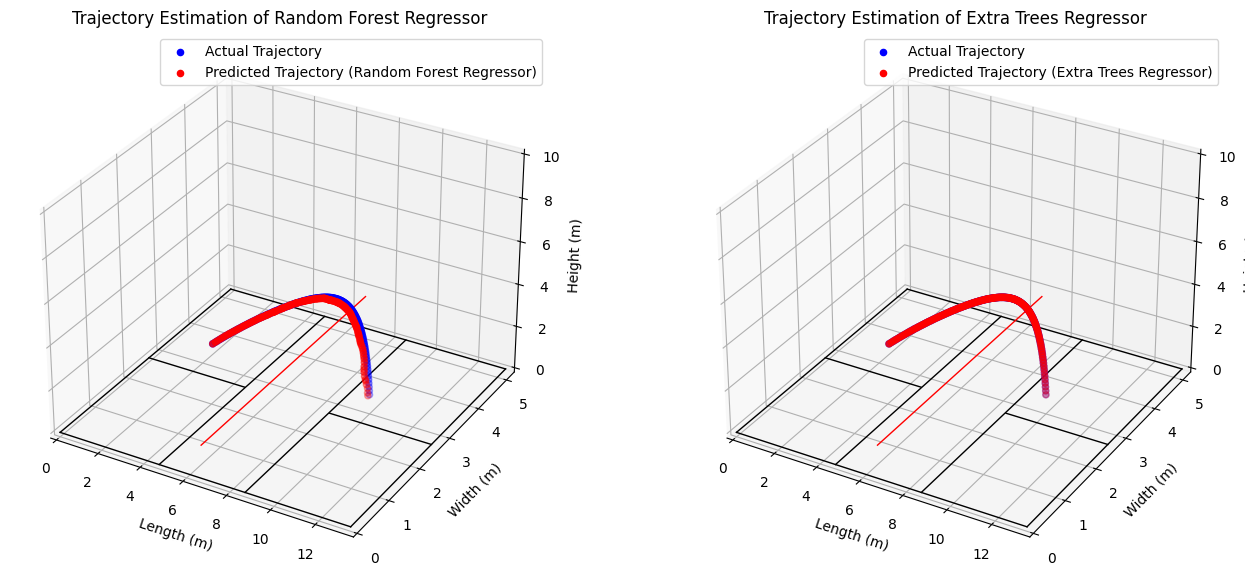

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), subplot_kw={'projection': '3d'})

# Set titles for subplots
axes[0].set_title("Trajectory Estimation of Random Forest Regressor")
axes[1].set_title("Trajectory Estimation of Extra Trees Regressor")

# Define court dimensions
court_length_x = 13.4
court_length_y = 5.18
court_height_skybox = 10
court_height_net = 1.55
court_height_robotbadminton_center = 1.1
court_length_centerline = 4.68

# Loop over subplots
for ax_index, ax in enumerate(axes):
    # Plot court boundaries
    ax.plot([0, court_length_x], [0, 0], [0, 0], color='black', linewidth=1)  # Bottom boundary
    ax.plot([0, court_length_x], [court_length_y, court_length_y], [0, 0], color='black', linewidth=1)  # Top boundary
    ax.plot([0, 0], [0, court_length_y], [0, 0], color='black', linewidth=1)  # Left boundary
    ax.plot([court_length_x, court_length_x], [0, court_length_y], [0, 0], color='black', linewidth=1)  # Right boundary

    # Plot center line
    ax.plot([0, court_length_centerline], [court_length_y / 2, court_length_y / 2], [0, 0], color='black', linewidth=1)
    ax.plot([court_length_x - court_length_centerline, court_length_x], [court_length_y / 2, court_length_y / 2], [0, 0], color='black', linewidth=1)

    # Plot short service lines
    ax.plot([court_length_centerline + 0.04, court_length_centerline + 0.04], [0, court_length_y], [0, 0], color='black', linewidth=1)
    ax.plot([court_length_x - court_length_centerline - 0.04, court_length_x - court_length_centerline - 0.04], [0, court_length_y], [0, 0], color='black', linewidth=1)

    # Plot net
    net_height = court_height_net
    ax.plot([court_length_x / 2, court_length_x / 2], [0, court_length_y], [net_height, net_height], color='red', linewidth=1)

    # Set plot limits and labels
    ax.set_xlim([0, court_length_x])
    ax.set_ylim([0, court_length_y])
    ax.set_zlim([0, court_height_skybox])
    ax.set_xlabel('Length (m)')
    ax.set_ylabel('Width (m)')
    ax.set_zlabel('Height (m)')

    if ax_index == 0:
        columns_n = ['X', 'Y', 'Z']
        predicted_trajectory_points_RF_DF = pd.DataFrame(predicted_trajectory_points_RT, columns=columns_n)

        # Extract X, Y, Z coordinates from y_actual_test and predicted_trajectory_point
        x_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(X) metres']
        y_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Y) metres']
        z_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Z) metres']

        x_predicted = predicted_trajectory_points_RF_DF['X'].values
        y_predicted = predicted_trajectory_points_RF_DF['Y'].values
        z_predicted = predicted_trajectory_points_RF_DF['Z'].values

        ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual Trajectory')
        ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted Trajectory (Random Forest Regressor)')

    elif ax_index == 1:
        columns_n = ['X', 'Y', 'Z']
        predicted_trajectory_points_ET_DF = pd.DataFrame(predicted_trajectory_points_ET, columns=columns_n)

        # Extract X, Y, Z coordinates from y_actual_test and predicted_trajectory_point
        x_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(X) metres']
        y_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Y) metres']
        z_actual = y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Z) metres']

        x_predicted = predicted_trajectory_points_ET_DF['X'].values
        y_predicted = predicted_trajectory_points_ET_DF['Y'].values
        z_predicted = predicted_trajectory_points_ET_DF['Z'].values

        ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual Trajectory')
        ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted Trajectory (Extra Trees Regressor)')

    ax.legend()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()


3D Interactive Visualization of the Shuttlecock Trajectory

In [50]:
import plotly.graph_objects as go
import plotly.offline as offline

# Create a scatter plot for actual trajectory
actual_trace = go.Scatter3d(x=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(X) metres'],
                            y=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
                            z=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Z) metres'],
                            mode='markers',
                            marker=dict(color='blue'),
                            name='Actual Trajectory')

# Create a scatter plot for predicted trajectory using Random Forest Regressor
predicted_trace_RF = go.Scatter3d(x=predicted_trajectory_points_RT[:, 0],
                                  y=predicted_trajectory_points_RT[:, 1],
                                  z=predicted_trajectory_points_RT[:, 2],
                                  mode='markers',
                                  marker=dict(color='red'),
                                  name='Predicted Trajectory (Random Forest)')

# Create a scatter plot for predicted trajectory using Extra Trees Regressor
predicted_trace_ET = go.Scatter3d(x=predicted_trajectory_points_ET[:, 0],
                                  y=predicted_trajectory_points_ET[:, 1],
                                  z=predicted_trajectory_points_ET[:, 2],
                                  mode='markers',
                                  marker=dict(color='green'),
                                  name='Predicted Trajectory (Extra Trees)')

# Set the data trace
data = [actual_trace, predicted_trace_RF, predicted_trace_ET]

# Set layout and title
layout = go.Layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis=dict(range=[-15, 15]),  # Set X-axis range
        yaxis=dict(range=[-15, 15]),  # Set Y-axis range
        zaxis=dict(range=[0, 15])     # Set Z-axis range
    ),
    title='Actual vs Predicted Trajectory'
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Save the plot as an HTML file
offline.plot(fig, filename='interactive_models/normal_regression_trajectory.html')


'interactive_models/normal_regression_trajectory.html'

### ROBOT - Shuttlecock Trajectory Estimation

In [89]:
import plotly.graph_objects as go
# Define court dimensions
court_length_x = 13.4
court_length_y = 5.18
court_height_skybox = 10
court_height_net = 1.55
court_length_centerline = 4.68

def is_point_within_court(x, y, z, court_length_x, court_length_y, court_height_skybox):
    """
    Check if a point is within the court boundaries.
    
    Args:
        x (float): X-coordinate of the point
        y (float): Y-coordinate of the point
        z (float): Z-coordinate of the point
        court_length_x (float): Length of the court along the X-axis
        court_length_y (float): Length of the court along the Y-axis
        court_height_skybox (float): Height of the court's skybox
    
    Returns:
        bool: True if the point is within the court boundaries, False otherwise
    """
    return 0 <= x <= court_length_x and 0 <= y <= court_length_y and 0 <= z <= court_height_skybox


# Create the 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(X) metres'],
        y=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
        z=y_actual_coords['SHUTTLECOCK POSITIION IN AIR(Z) metres'],
        mode='markers',
        name='True Values',
        marker=dict(color='blue', size=2),
        opacity=0.7
    ),
    go.Scatter3d(
        x=predicted_trajectory_points_RT[:, 0],
        y=predicted_trajectory_points_RT[:, 1],
        z=predicted_trajectory_points_RT[:, 2],
        mode='markers',
        name='Predicted Values (Random Forest)',
        marker=dict(color='red', size=2),
        opacity=0.7
    ),
    go.Scatter3d(
        x=predicted_trajectory_points_ET[:, 0],
        y=predicted_trajectory_points_ET[:, 1],
        z=predicted_trajectory_points_ET[:, 2],
        mode='markers',
        name='Predicted Values (Extra Trees)',
        marker=dict(color='green', size=2),
        opacity=0.7
    ),
])

# Set plot title and axis labels
fig.update_layout(
    title='Shuttlecock Trajectory Estimation',
    scene=dict(
        xaxis_title='X-coordinate',
        yaxis_title='Y-coordinate',
        zaxis_title='Z-coordinate',
        xaxis=dict(range=[-4, 18]),  # Set the range for X-axis
        yaxis=dict(range=[-2, 7]),   # Set the range for Y-axis
        zaxis=dict(range=[0, 12]),  # Set the range for Z-axis
        aspectmode='manual',         # Set the aspect mode to manual for custom scaling
        aspectratio=dict(x=1, y=1, z=1)  # Set the aspect ratio for equal scaling of axes
    )
)

# Add court lines to the plot
fig.add_trace(go.Scatter3d(
    x=[0, court_length_x, court_length_x, 0, 0],
    y=[0, 0, court_length_y, court_length_y, 0],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    name='Court Boundaries',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[0, court_length_centerline, court_length_centerline, 0, 0],
    y=[court_length_y / 2, court_length_y / 2, court_length_y / 2, court_length_y / 2, court_length_y / 2],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    name='Center Line',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_x - court_length_centerline, court_length_x],
    y=[court_length_y / 2, court_length_y / 2],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    name='Center Line',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_centerline + 0.04, court_length_centerline + 0.04],
    y=[0, court_length_y],
    z=[0, 0],
    mode='lines',
    name='Short Service Lines',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_x - court_length_centerline - 0.04, court_length_x - court_length_centerline - 0.04],
    y=[0, court_length_y],
    z=[0, 0],
    mode='lines',
    name='Short Service Lines',
    line=dict(color='black', width=1)
))

fig.add_trace(go.Scatter3d(
    x=[court_length_x / 2, court_length_x / 2],
    y=[0, court_length_y],
    z=[court_height_net, court_height_net],
    mode='lines',
    name='Net',
    line=dict(color='red', width=1)
))

# Initialize variables
all_within_court_RT = True
all_within_court_ET = True
highest_xyz_points_RT = []
highest_xyz_points_ET = []
highest_z_index_RT = np.argmax(predicted_trajectory_points_RT[:, 2])
highest_z_index_ET = np.argmax(predicted_trajectory_points_ET[:, 2])

# Check if all predicted values for the RT group are within the court
for point in predicted_trajectory_points_RT:
    x, y, z = point
    if not is_point_within_court(x, y, z, court_length_x, court_length_y, court_height_skybox):
        all_within_court_RT = False
        break

# Check if all predicted values for the ET group are within the court
for point in predicted_trajectory_points_ET:
    x, y, z = point
    if not is_point_within_court(x, y, z, court_length_x, court_length_y, court_height_skybox):
        all_within_court_ET = False
        break

color = "red"
predict = True
placeholder="Initial Starting Point (Miss)"
            
if not (all_within_court_RT and all_within_court_ET):
    color = "black"
    predict = False
    placeholder="Initial Starting Point (OUT)"
        
highest_xyz_points_RT = predicted_trajectory_points_RT[-1]
highest_xyz_point_RT = predicted_trajectory_points_RT[highest_z_index_RT]
highest_xyz_points_ET = predicted_trajectory_points_ET[-1]
highest_xyz_point_ET = predicted_trajectory_points_ET[highest_z_index_ET]
    
# Average out the predicted XYZ points
average_xyz = np.mean([highest_xyz_points_RT, highest_xyz_points_ET], axis=0)
# Average out the highest XYZ points
average_highest_xyz = np.mean([highest_xyz_point_RT, highest_xyz_point_ET], axis=0)

# Print the count
print("Is predicted Regression Tree (RT) within court: ", all_within_court_RT)
print("Is predicted Extra Tree (ET) within court: ", all_within_court_ET)
# Print the average XYZ values
print("Average XYZ of Estimated Shuttlecock Position:", average_xyz)

# Add the average predicted X, Y, and Z points to the graph
fig.add_trace(go.Scatter3d(
    x=[average_xyz[0]],
    y=[average_xyz[1]],
    z=[average_xyz[2]],
    mode='lines+markers',
    name='Predicted Position',
    line=dict(color="green", width=5),
    marker=dict(symbol="cross", size=10, color="cyan", line=dict(color="black", width=4)),
    opacity=1
))

# Add the average highest X, Y, and Z points to the graph
fig.add_trace(go.Scatter3d(
    x=[average_highest_xyz[0]],
    y=[average_highest_xyz[1]],
    z=[average_highest_xyz[2]],
    mode='lines+markers',
    name='Average Highest XYZ-point',
    line=dict(color="green", width=5),
    marker=dict(symbol="diamond", size=6, color="cyan", line=dict(color="black", width=4)),
    opacity=1
))

# Calculate the height of the badminton racket from the ground
badminton_height = (120 / 100) - (0.17/2)  # -> 0.17/2 assuming we want to hit it somewhere in the middle of the top quarter

# Calculate the length and width of the robot
robot_length = 20.4 / 100  # Convert length from cm to meters
robot_width = 23 / 100  # Convert width from cm to meters

# Define the range for the initial starting position
x_range = [0, 4.72]
y_range = [0, 5.18]

# Define number of random positions to test
no_of_random_pos = 3

for i in range(no_of_random_pos):
    # Generate random initial starting position within the specified range
    random_initial_x = random.uniform(x_range[0], x_range[1])
    random_initial_y = random.uniform(y_range[0], y_range[1])

    # Calculate the position where the dummy robot should move to
    robot_x = court_length_x - average_xyz[0] - robot_length - random_initial_x
    robot_y = court_length_y - average_xyz[1] - robot_width - random_initial_y

    # Calculate the distance traveled by the robot
    robot_distance = np.sqrt(robot_x ** 2 + robot_y ** 2)
    # Calculate the time required for the robot to move to the position
    robot_movement_time = robot_distance / 3
    if (all_within_court_RT and all_within_court_ET):
        print("Distance: {:.2f} meters in {:.2f} seconds".format(robot_distance, robot_movement_time))

    # Calculate the adjusted z-coordinate for hitting the shuttlecock
    robot_z = average_highest_xyz[2] - badminton_height

    # Check if the average highest XYZ-point is within the court and the robot can reach the position before the ball drops
    if (
        average_xyz[0] >= 0
        and average_xyz[0] <= court_length_x
        and average_xyz[1] >= 0
        and average_xyz[1] <= court_length_y
        and average_highest_xyz[2] >= 0
        and average_highest_xyz[2] <= court_height_skybox
        and robot_movement_time <= 1.5
        and robot_z >= 0
    ):
        # Add the initial starting point of the dummy robot to the graph
        fig.add_trace(
            go.Scatter3d(
                x=[court_length_x - random_initial_x],
                y=[court_length_y - random_initial_y],
                z=[badminton_height],
                mode="markers",
                name="Initial Starting Point (Hit)",
                marker=dict(color="blue", size=10),
                opacity=1,
            )
        )

        # Calculate the (x, y) difference
        x_difference = robot_x
        y_difference = robot_y
        
        if (all_within_court_RT and all_within_court_ET):
            print(f"X difference: {x_difference}")
            print(f"Y difference: {y_difference}")
            print(f"Time required: {robot_movement_time} seconds")
            print("Able to reach and hit on time")
    else:
        # Add the initial starting point of the dummy robot to the graph
        fig.add_trace(
            go.Scatter3d(
                x=[court_length_x - random_initial_x],
                y=[court_length_y - random_initial_y],
                z=[badminton_height],
                mode="markers",
                name=placeholder,
                marker=dict(color=color, size=10),
                opacity=0.3,
            )
        )
        
        if (all_within_court_RT and all_within_court_ET):
            if robot_movement_time > 1.5:
                print(f"X difference: {x_difference}")
                print(f"Y difference: {y_difference}")
                print(f"Time required: {robot_movement_time} seconds")
                print("Cannot reach on time")
            else:
                print("Cannot hit")

if (all_within_court_RT and all_within_court_ET):
    # Add the point where the dummy robot can hit the ball to the graph
    fig.add_trace(
        go.Scatter3d(
            x=[court_length_x - random_initial_x - robot_x],
            y=[court_length_y - random_initial_y - robot_y],
            z=[badminton_height],
            mode="markers",
            name="Point to Hit the Ball",
            marker=dict(color="green", size=10),
            opacity=1,
        )
)

# Show the 3D plot
fig.show()

# Save the plot as an HTML file
offline.plot(fig, filename='interactive_models/robot_pred_limited_reg.html')

Is predicted Regression Tree (RT) within court:  True
Is predicted Extra Tree (ET) within court:  True
Average XYZ of Estimated Shuttlecock Position: [9.47750096 3.33779208 0.05486448]
Distance: 2.76 meters in 0.92 seconds
X difference: 2.418982251759405
Y difference: -1.3342802630214226
Time required: 0.9208558190084505 seconds
Able to reach and hit on time
Distance: 1.32 meters in 0.44 seconds
X difference: 0.6535585242838176
Y difference: 1.1438635500663545
Time required: 0.4391358389982718 seconds
Able to reach and hit on time
Distance: 3.59 meters in 1.20 seconds
X difference: 3.561216909311176
Y difference: -0.42700383484111226
Time required: 1.195575089427346 seconds
Able to reach and hit on time


'interactive_models/robot_pred_limited_reg.html'

## Determine Point for Countermeasures
Based on the project specificiations where 
- robot + badminton height=120cm
- racket length is 68cm
- robot lenght is 52cm
- assuming top quarter of racket is top 17cm
We assume that robot countermeasure will happen at Z = 1.2 - (0.17/2) = 1.115 because we want to hit it somewhere in the middle of the top quarter

In [84]:
# # filter out records that are under X = 6.7
# filtered_df = predicted_trajectory_points_RF_DF[predicted_trajectory_points_RF_DF['X'] > 6.7]

# # Determine absolute difference between Z and 1.115 for the filtered dataframe
# filtered_df['Z_diff'] = abs(filtered_df['Z'] - 1.115)

# # Find the row index with the minimum difference
# closest_row_index = filtered_df['Z_diff'].idxmin()

# # Access the row with the closest Z value in the filtered dataframe
# closest_row = filtered_df.loc[closest_row_index]

# # Print the row or perform further operations
# print("Data Point closest to countermeasure")
# print(closest_row)